# Init spark

In [ ]:
import findspark
findspark.init()

from pyspark import SparkContext

# Init sparkcontext
sc = SparkContext(master="local", appName="APP")

from pyspark.sql import SparkSession
spark = SparkSession(sc)
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/27 09:23:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Import library

In [2]:
import pyspark.sql.functions as f
import pyspark.sql.types as t

import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import pyspark.sql.types as t

# Import data

- CUST_ID : Identification of Credit Card holder (Categorical)
- BALANCE : Balance amount left in their account to make purchases (
- BALANCE_FREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
- PURCHASES : Amount of purchases made from account
- ONEOFF_PURCHASES : Maximum purchase amount done in one-go
- INSTALLMENTS_PURCHASES : Amount of purchase done in installment
- CASH_ADVANCE : Cash in advance given by the user
- PURCHASES_FREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
- ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
- PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
- CASHADVANCEFREQUENCY : How frequently the cash in advance being paid
- CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"
- PURCHASES_TRX : Numbe of purchase transactions made
- CREDIT_LIMIT : Limit of Credit Card for user
- PAYMENTS : Amount of Payment done by user
- MINIMUM_PAYMENTS : Minimum amount of payments made by user
- PRCFULLPAYMENT : Percent of full payment paid by user
- TENURE : Tenure of credit card service for use

In [3]:
df = spark.read.csv('/Users/phungtran/Library/Mobile Documents/com~apple~CloudDocs/Documents/Learning/Data_science/DL06_v2_BigData/Bai_Thi_Cuoi_ky/Data/CC_GENERAL.csv', header=True, inferSchema=True)
df.show(5)

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+
| C10001|  40.900749|         0.818182|     95.4|             0.0|                  95.4|  

# Explore data

In [4]:
df.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)



In [5]:
df.describe().show()

25/01/27 09:23:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------+------------------+-------------------+------------------+------------------+----------------------+------------------+-------------------+--------------------------+--------------------------------+----------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+
|summary|CUST_ID|           BALANCE|  BALANCE_FREQUENCY|         PURCHASES|  ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|      CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|  CASH_ADVANCE_TRX|     PURCHASES_TRX|     CREDIT_LIMIT|          PAYMENTS| MINIMUM_PAYMENTS|  PRC_FULL_PAYMENT|           TENURE|
+-------+-------+------------------+-------------------+------------------+------------------+----------------------+------------------+-------------------+--------------------------+--------------------------------+----------------------+------------------+--

In [6]:
print(len(df.columns), df.columns)

18 ['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']


In [ ]:
# Check NA values 
for col in df.columns:
    print(col, df.where(df[col].isNull()).count())

CUST_ID 0
BALANCE 0
BALANCE_FREQUENCY 0
PURCHASES 0
ONEOFF_PURCHASES 0
INSTALLMENTS_PURCHASES 0
CASH_ADVANCE 0
PURCHASES_FREQUENCY 0
ONEOFF_PURCHASES_FREQUENCY 0
PURCHASES_INSTALLMENTS_FREQUENCY 0
CASH_ADVANCE_FREQUENCY 0
CASH_ADVANCE_TRX 0
PURCHASES_TRX 0
CREDIT_LIMIT 1
PAYMENTS 0
MINIMUM_PAYMENTS 313
PRC_FULL_PAYMENT 0
TENURE 0


There are NAs at CREDIT_LIMIT and MINIMUM_PAYMENTS columns

In [8]:
# drop na
df = df.na.drop()

In [9]:
# drop duplicated values (if any)
df = df.dropDuplicates()

## Define numerical and categorical data

In [10]:
df.schema.fields

[StructField('CUST_ID', StringType(), True),
 StructField('BALANCE', DoubleType(), True),
 StructField('BALANCE_FREQUENCY', DoubleType(), True),
 StructField('PURCHASES', DoubleType(), True),
 StructField('ONEOFF_PURCHASES', DoubleType(), True),
 StructField('INSTALLMENTS_PURCHASES', DoubleType(), True),
 StructField('CASH_ADVANCE', DoubleType(), True),
 StructField('PURCHASES_FREQUENCY', DoubleType(), True),
 StructField('ONEOFF_PURCHASES_FREQUENCY', DoubleType(), True),
 StructField('PURCHASES_INSTALLMENTS_FREQUENCY', DoubleType(), True),
 StructField('CASH_ADVANCE_FREQUENCY', DoubleType(), True),
 StructField('CASH_ADVANCE_TRX', IntegerType(), True),
 StructField('PURCHASES_TRX', IntegerType(), True),
 StructField('CREDIT_LIMIT', DoubleType(), True),
 StructField('PAYMENTS', DoubleType(), True),
 StructField('MINIMUM_PAYMENTS', DoubleType(), True),
 StructField('PRC_FULL_PAYMENT', DoubleType(), True),
 StructField('TENURE', IntegerType(), True)]

In [11]:
# check categorical variables
str_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, t.StringType)]
str_cols

['CUST_ID']

In [12]:
# check numerical variables
float_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, t.DoubleType)]
float_cols

['BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT']

In [13]:
# check numerical variables
int_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, t.IntegerType)]
int_cols

['CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'TENURE']

In [14]:
# Define final numerical columns
num_cols = float_cols + int_cols

In [15]:
# filter relevant columns for credit card usage
relevant_columns = ['INSTALLMENTS_PURCHASES', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE', 'CASH_ADVANCE_FREQUENCY',
 'TENURE','CASH_ADVANCE_TRX', 'CREDIT_LIMIT']

I perform univariate and bivariate analysis for selected columns (relevant_columns)

## Analyze 1 variable

======= col name: INSTALLMENTS_PURCHASES ====================
Distinct values: 4341
+-------+----------------------+
|summary|INSTALLMENTS_PURCHASES|
+-------+----------------------+
|  count|                  8636|
|   mean|     420.8435328855941|
| stddev|     917.2451824827328|
|    min|                   0.0|
|    max|               22500.0|
+-------+----------------------+

None
+------------------------------+
|median(INSTALLMENTS_PURCHASES)|
+------------------------------+
|                        94.785|
+------------------------------+

None


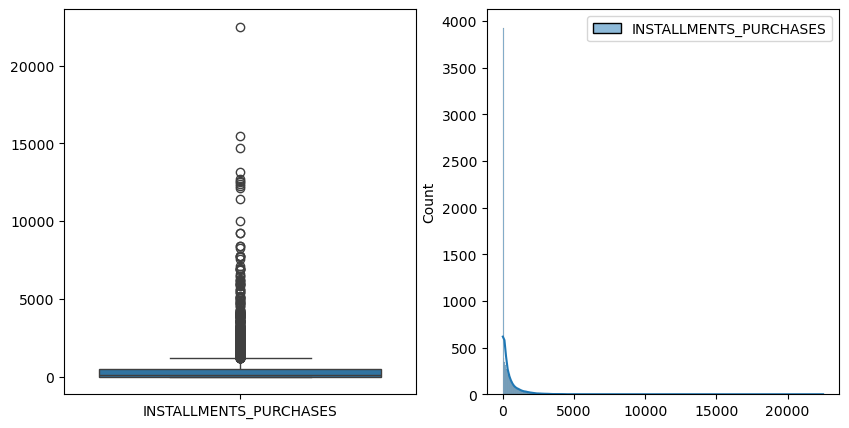

======= col name: PURCHASES_INSTALLMENTS_FREQUENCY ====================
Distinct values: 47
+-------+--------------------------------+
|summary|PURCHASES_INSTALLMENTS_FREQUENCY|
+-------+--------------------------------+
|  count|                            8636|
|   mean|              0.3688203456461315|
| stddev|             0.39809294421484664|
|    min|                             0.0|
|    max|                             1.0|
+-------+--------------------------------+

None
+----------------------------------------+
|median(PURCHASES_INSTALLMENTS_FREQUENCY)|
+----------------------------------------+
|                                0.166667|
+----------------------------------------+

None


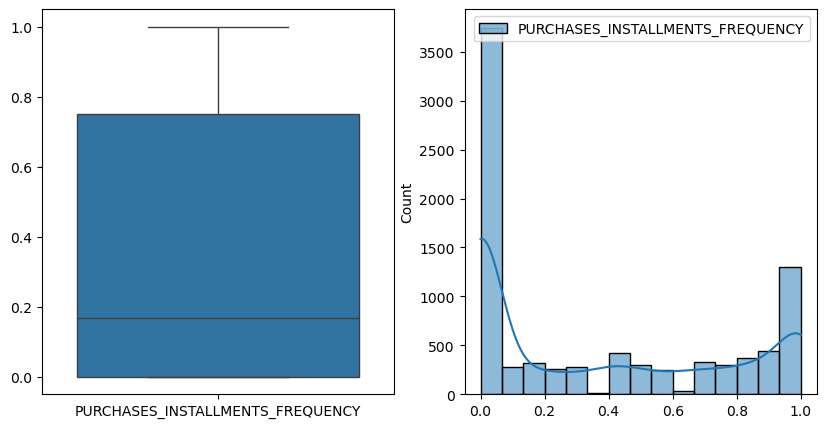

======= col name: CASH_ADVANCE ====================
Distinct values: 4206
+-------+------------------+
|summary|      CASH_ADVANCE|
+-------+------------------+
|  count|              8636|
|   mean| 994.1755230371688|
| stddev|2121.4583028800225|
|    min|               0.0|
|    max|       47137.21176|
+-------+------------------+

None
+--------------------+
|median(CASH_ADVANCE)|
+--------------------+
|                 0.0|
+--------------------+

None


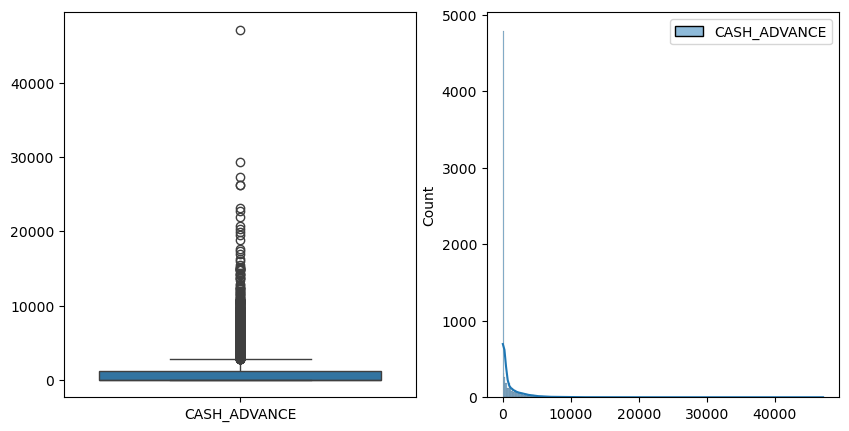

======= col name: CASH_ADVANCE_FREQUENCY ====================
Distinct values: 54
+-------+----------------------+
|summary|CASH_ADVANCE_FREQUENCY|
+-------+----------------------+
|  count|                  8636|
|   mean|   0.13760420426123338|
| stddev|   0.20179143060679372|
|    min|                   0.0|
|    max|                   1.5|
+-------+----------------------+

None
+------------------------------+
|median(CASH_ADVANCE_FREQUENCY)|
+------------------------------+
|                           0.0|
+------------------------------+

None


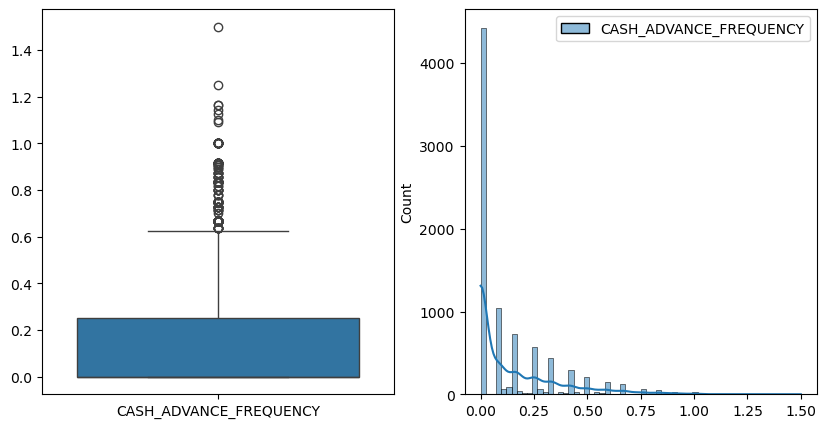

======= col name: TENURE ====================
+------+-----+
|TENURE|count|
+------+-----+
|    12| 7346|
|    11|  356|
|    10|  226|
|     6|  184|
|     8|  183|
|     7|  177|
|     9|  164|
+------+-----+

None
======= col name: CASH_ADVANCE_TRX ====================
Distinct values: 65


25/01/27 09:23:18 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-------+------------------+
|summary|  CASH_ADVANCE_TRX|
+-------+------------------+
|  count|              8636|
|   mean| 3.313918480778138|
| stddev|6.9125061173263305|
|    min|                 0|
|    max|               123|
+-------+------------------+

None
+------------------------+
|median(CASH_ADVANCE_TRX)|
+------------------------+
|                     0.0|
+------------------------+

None


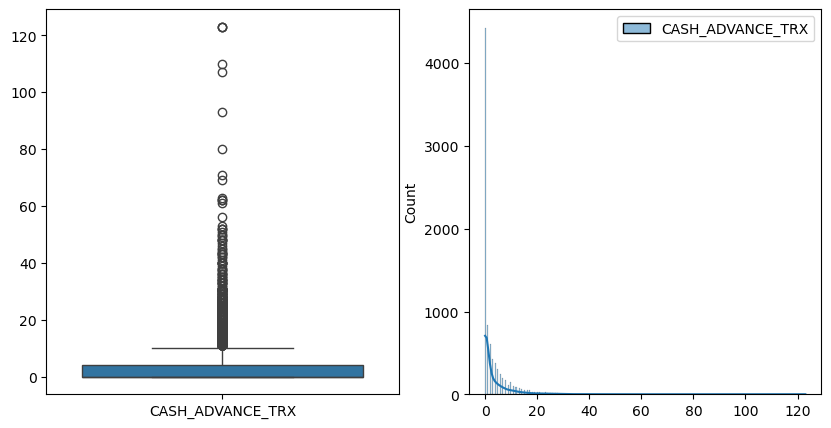

======= col name: CREDIT_LIMIT ====================
Distinct values: 203
+-------+-----------------+
|summary|     CREDIT_LIMIT|
+-------+-----------------+
|  count|             8636|
|   mean|4522.091029563802|
| stddev|3659.240379277945|
|    min|             50.0|
|    max|          30000.0|
+-------+-----------------+

None
+--------------------+
|median(CREDIT_LIMIT)|
+--------------------+
|              3000.0|
+--------------------+

None


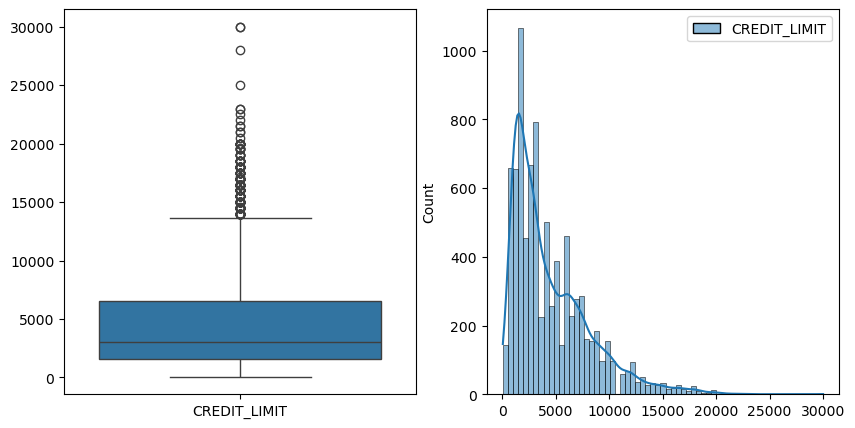

In [ ]:
# check numerical variables
for col in relevant_columns:
    print('======= col name:',col, '=='*10)
    # If the column has fewer than 20 distinct values, treat it as categorical and show counts
    if df.select(col).distinct().count() < 20:
        # Print number of distinct values
        print(df.groupBy(col).count().orderBy('count', ascending=False).show())
    else:
        # Print number of distinct values
        print('Distinct values:', df.select(col).distinct().count())
        # Show basic descriptive statistics (mean, std, min, max)
        print(df.select(col).describe().show())
        # Show the median value
        print(df.select(f.median(col)).show())
        
        # Convert the column to a Pandas Series for plotting
        col_pd = df.select(col).toPandas()

        # Plot boxplot and histogram to visualize distribution and outliers
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        sns.boxplot(col_pd)

        plt.subplot(1,2,2)
        sns.histplot(col_pd, kde=True)

        plt.show()


## Analyze numerical x numerical

In [17]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# Combines multiple columns into a single feature vector column
continuous_features = VectorAssembler(
    inputCols=relevant_columns, outputCol="num_features"
)

num_df = df.select(relevant_columns)
num_transform = continuous_features.transform(num_df)


In [18]:
num_transform.show(5)

+----------------------+--------------------------------+------------+----------------------+------+----------------+------------+--------------------+
|INSTALLMENTS_PURCHASES|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE|CASH_ADVANCE_FREQUENCY|TENURE|CASH_ADVANCE_TRX|CREDIT_LIMIT|        num_features|
+----------------------+--------------------------------+------------+----------------------+------+----------------+------------+--------------------+
|                   0.0|                             0.0|  2792.67597|                  0.25|    12|               3|      6000.0|[0.0,0.0,2792.675...|
|                699.12|                             1.0|         0.0|                   0.0|    12|               0|      2500.0|[699.12,1.0,0.0,0...|
|                   0.0|                             0.0| 3550.209696|              0.166667|    12|               3|      5500.0|[0.0,0.0,3550.209...|
|               1606.66|                             1.0|         0.0|                  

In [19]:
# compute correlation matrices
correlation = Correlation.corr(
    num_transform, "num_features" 
)

25/01/27 09:23:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/01/27 09:23:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [20]:
# extract correlation array
correlation_array = correlation.head()[0].toArray()  
correlation_array

array([[ 1.        ,  0.5111303 , -0.06609907, -0.13645481,  0.08334567,
        -0.0767158 ,  0.25805749],
       [ 0.5111303 ,  1.        , -0.17887343, -0.26892396,  0.06577935,
        -0.1728109 ,  0.06342088],
       [-0.06609907, -0.17887343,  1.        ,  0.62903025, -0.07308979,
         0.65691147,  0.30416069],
       [-0.13645481, -0.26892396,  0.62903025,  1.        , -0.14003762,
         0.79959285,  0.13284059],
       [ 0.08334567,  0.06577935, -0.07308979, -0.14003762,  1.        ,
        -0.0453501 ,  0.13646382],
       [-0.0767158 , -0.1728109 ,  0.65691147,  0.79959285, -0.0453501 ,
         1.        ,  0.15026109],
       [ 0.25805749,  0.06342088,  0.30416069,  0.13284059,  0.13646382,
         0.15026109,  1.        ]])

In [21]:
# create dataframe from the correlation matrix
correlation_pd = pd.DataFrame(
    correlation_array,                            
    index=relevant_columns,                              
    columns=relevant_columns,                            
)
correlation_pd

,INSTALLMENTS_PURCHASES,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,TENURE,CASH_ADVANCE_TRX,CREDIT_LIMIT
INSTALLMENTS_PURCHASES,1.000000,0.511130,-0.066099,-0.136455,0.083346,-0.076716,0.258057
PURCHASES_INSTALLMENTS_FREQUENCY,0.511130,1.000000,-0.178873,-0.268924,0.065779,-0.172811,0.063421
CASH_ADVANCE,-0.066099,-0.178873,1.000000,0.629030,-0.073090,0.656911,0.304161
CASH_ADVANCE_FREQUENCY,-0.136455,-0.268924,0.629030,1.000000,-0.140038,0.799593,0.132841
TENURE,0.083346,0.065779,-0.073090,-0.140038,1.000000,-0.045350,0.136464
CASH_ADVANCE_TRX,-0.076716,-0.172811,0.656911,0.799593,-0.045350,1.000000,0.150261
CREDIT_LIMIT,0.258057,0.063421,0.304161,0.132841,0.136464,0.150261,1.000000


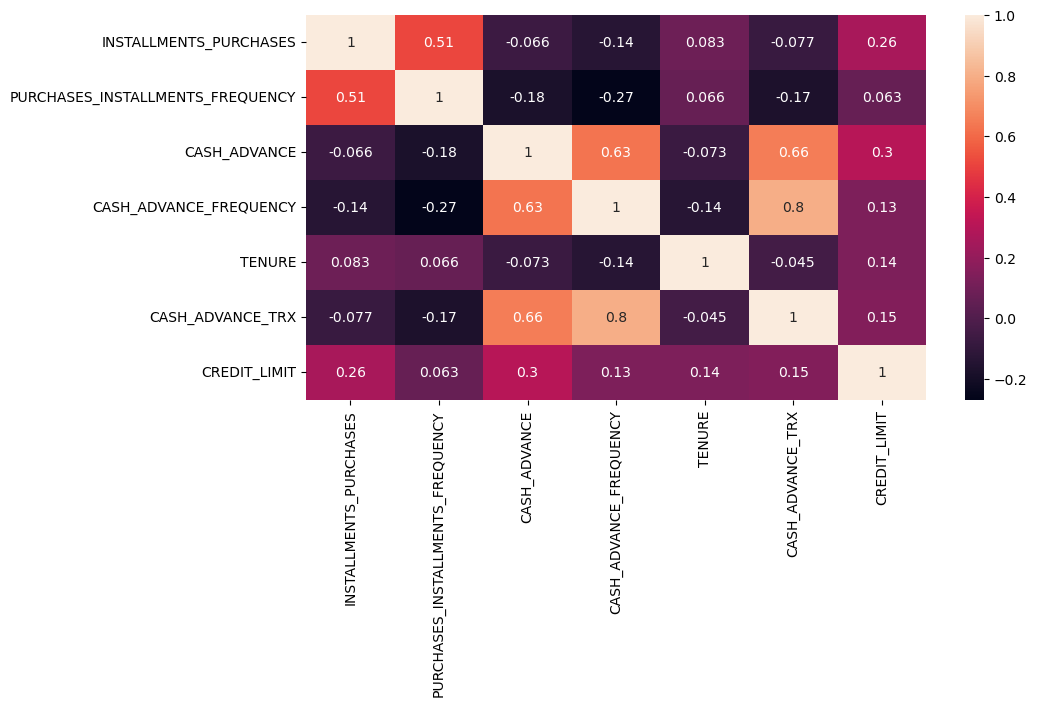

In [22]:
# Visualiza correlation matrix
import seaborn as sns 
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,5))
sns.heatmap(correlation_pd, annot=True)
plt.show()

Remove any columns that are highly correlated and identify the final set of columns to be used for clustering

In [87]:
final_columns = ['INSTALLMENTS_PURCHASES', 'CASH_ADVANCE','CREDIT_LIMIT' ]

In [118]:
df_final = df[final_columns]

## Remove outliers

In [119]:
df_final.count()

8636

In [120]:
for col in final_columns:
    print('Starting.....', col)
    print('Before removing outliers:', df_final.select(col).count())
    mean_val = df_final.agg({col: 'mean'}).collect()[0][0]
    stddev_val = df_final.agg({col:'stddev'}).collect()[0][0]

    low_bound = mean_val - (3 * stddev_val)
    hi_bound = mean_val + (3 * stddev_val)

    df_final = df_final.where((df_final[col]<hi_bound) & (df_final[col]> low_bound))

    print('After removing outliers:', df_final.select(col).count())
    print(' ')

Starting..... INSTALLMENTS_PURCHASES
Before removing outliers: 8636
After removing outliers: 8506
 
Starting..... CASH_ADVANCE
Before removing outliers: 8506
After removing outliers: 8333
 
Starting..... CREDIT_LIMIT
Before removing outliers: 8333
After removing outliers: 8192
 


# Transformer

In [121]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

Transform columns to be features

In [122]:
vec_assembler = VectorAssembler(inputCols = df_final.columns,
                                outputCol='features')

In [123]:
final_data = vec_assembler.transform(df_final)

# Scale the data

We observe that data is not normal distribution and has outliers. Therefore, I apply RobustScaler for the dataset

In [124]:
from pyspark.ml.feature import RobustScaler

In [125]:
scaler = RobustScaler(inputCol="features", outputCol="scaledFeatures")

In [126]:
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

In [127]:
# Normalize each feature to have unit standard deviation.
final_data = scalerModel.transform(final_data)

In [128]:
final_data.show(3, False)

+----------------------+------------+------------+------------------------+-------------------------------------------+
|INSTALLMENTS_PURCHASES|CASH_ADVANCE|CREDIT_LIMIT|features                |scaledFeatures                             |
+----------------------+------------+------------+------------------------+-------------------------------------------+
|0.0                   |2792.67597  |6000.0      |[0.0,2792.67597,6000.0] |[0.0,2.7166965315513294,1.3333333333333335]|
|699.12                |0.0         |2500.0      |[699.12,0.0,2500.0]     |[1.549811571713589,0.0,0.5555555555555556] |
|0.0                   |3550.209696 |5500.0      |[0.0,3550.209696,5500.0]|[0.0,3.4536202806955436,1.2222222222222223]|
+----------------------+------------+------------+------------------------+-------------------------------------------+
only showing top 3 rows



# Build model

## Find K using Silhouette method

In [129]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [130]:
# Trains a k-means model.
k_list = []
silhouette_list = []
sil_str = ""

for k in range(2,11):
    kmeans = KMeans(featuresCol='scaledFeatures',k=k)
    model = kmeans.fit(final_data)
    k_list.append(k)

    # silhoutte
    predictions = model.transform(final_data)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_list.append(silhouette)

    sil_str = sil_str + "With k =" + str(k) + "- Silhouette = " + str(silhouette) + "\n"

In [131]:
print(sil_str)

With k =2- Silhouette = 0.19548907498249632
With k =3- Silhouette = 0.2920228726345517
With k =4- Silhouette = 0.4929406398892191
With k =5- Silhouette = 0.3981120887738307
With k =6- Silhouette = 0.2666336752806289
With k =7- Silhouette = 0.18943733945287117
With k =8- Silhouette = 0.0667551964661013
With k =9- Silhouette = 0.002989464198035999
With k =10- Silhouette = 0.02216846682518805



In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

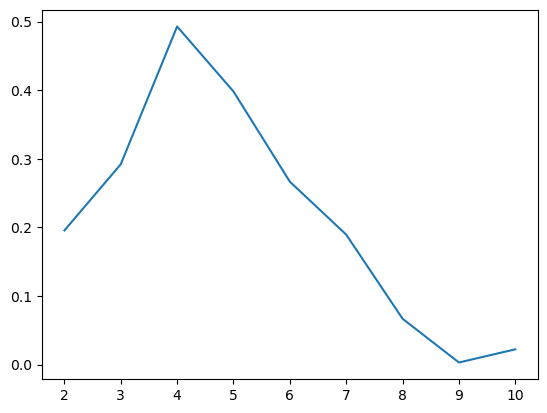

In [133]:
plt.plot(k_list, silhouette_list)
plt.show()

## Select K = 4

In [134]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='scaledFeatures', k=4)
model = kmeans.fit(final_data)

In [135]:
# silhoutte
predictions = model.transform(final_data)
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhoutte = " + str(silhouette))

Silhoutte = 0.4929406398892191


In [136]:
# Shows the center points.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[3.43015006 0.28270787 1.17814535]
[0.31819368 3.60859901 1.36070743]
[0.36365724 0.32467329 0.48781442]
[0.51828295 0.26283974 1.73949903]


In [137]:
centers_df = pd.DataFrame(centers)
centers_df = centers_df.rename(columns={0: "x_center", 1: "y_center", 2: "z_center"})
centers_df.head()

,x_center,y_center,z_center
0,3.430150,0.282708,1.178145
1,0.318194,3.608599,1.360707
2,0.363657,0.324673,0.487814
3,0.518283,0.262840,1.739499


In [138]:
predictions =  model.transform(final_data)

In [139]:
predictions.show(5)

+----------------------+------------+------------+--------------------+--------------------+----------+
|INSTALLMENTS_PURCHASES|CASH_ADVANCE|CREDIT_LIMIT|            features|      scaledFeatures|prediction|
+----------------------+------------+------------+--------------------+--------------------+----------+
|                   0.0|  2792.67597|      6000.0|[0.0,2792.67597,6...|[0.0,2.7166965315...|         1|
|                699.12|         0.0|      2500.0| [699.12,0.0,2500.0]|[1.54981157171358...|         2|
|                   0.0| 3550.209696|      5500.0|[0.0,3550.209696,...|[0.0,3.4536202806...|         1|
|                140.96| 3808.247988|      7500.0|[140.96,3808.2479...|[0.31248060297051...|         1|
|                   0.0|         0.0|      1200.0|    [0.0,0.0,1200.0]|[0.0,0.0,0.266666...|         2|
+----------------------+------------+------------+--------------------+--------------------+----------+
only showing top 5 rows



In [140]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 1126|
|         3| 1461|
|         2| 4636|
|         0|  969|
+----------+-----+



In [141]:
predictions.groupBy('prediction').agg(
    f.count('INSTALLMENTS_PURCHASES').alias('num_values'),
    f.mean('INSTALLMENTS_PURCHASES'),
    f.mean('CASH_ADVANCE'),
    f.mean('CREDIT_LIMIT')
).show()

+----------+----------+---------------------------+------------------+-----------------+
|prediction|num_values|avg(INSTALLMENTS_PURCHASES)| avg(CASH_ADVANCE)|avg(CREDIT_LIMIT)|
+----------+----------+---------------------------+------------------+-----------------+
|         1|      1126|         143.53716696269984|3709.5228089440498|6123.183432908525|
|         3|      1461|         233.79744010951404|270.19073421629025|7827.745628772074|
|         2|      4636|         164.04578084555664|333.75361447972335|2195.164893106989|
|         0|       969|         1547.3406914344669| 290.6145215686274|5301.654053434469|
+----------+----------+---------------------------+------------------+-----------------+



In [158]:
# rename groups for interpretation
predictions = predictions.withColumn(
    "customer_type",
    f.when(f.col('prediction') == 0, 'Installment Users')
    .when(f.col('prediction')==1, 'Cash Users')
    .when(f.col('prediction')==2, 'Potential Users')
    .when(f.col('prediction')==3, 'Need Attention')
)
predictions.show(5)

+----------------------+------------+------------+--------------------+--------------------+----------+---------------+
|INSTALLMENTS_PURCHASES|CASH_ADVANCE|CREDIT_LIMIT|            features|      scaledFeatures|prediction|  customer_type|
+----------------------+------------+------------+--------------------+--------------------+----------+---------------+
|                   0.0|  2792.67597|      6000.0|[0.0,2792.67597,6...|[0.0,2.7166965315...|         1|     Cash Users|
|                699.12|         0.0|      2500.0| [699.12,0.0,2500.0]|[1.54981157171358...|         2|Potential Users|
|                   0.0| 3550.209696|      5500.0|[0.0,3550.209696,...|[0.0,3.4536202806...|         1|     Cash Users|
|                140.96| 3808.247988|      7500.0|[140.96,3808.2479...|[0.31248060297051...|         1|     Cash Users|
|                   0.0|         0.0|      1200.0|    [0.0,0.0,1200.0]|[0.0,0.0,0.266666...|         2|Potential Users|
+----------------------+------------+---

After clustering with 3 groups, we can see that
- **Group no.0** [INSTALLMENT USERS](969 records): showing highest spending on installment purchases (1547,34). However, they have lower cash advance activity compared to other groups and have average credit limit

- **Group no.1** [CASH USERS] (1126 records): having lowest avg spending on installment purchases. However, they have highest cash advance activity

- **Group no.2** [POTENTIAL USERS] (4636 records): having lower avg spending on BOTH installment purchases and cash advance activity although having highest credit limit

- **Group no.3** [NEED ATTENTION] (1461 records) :having lower avg spending on BOTH installment purchases and cash advance activity

# Visualize result

In [159]:
data = predictions.toPandas()
data.head()

,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,features,scaledFeatures,prediction,customer_type
0,0.00,2792.675970,6000.0,"[0.0, 2792.67597, 6000.0]","[0.0, 2.7166965315513294, 1.3333333333333335]",1,Cash Users
1,699.12,0.000000,2500.0,"[699.12, 0.0, 2500.0]","[1.549811571713589, 0.0, 0.5555555555555556]",2,Potential Users
2,0.00,3550.209696,5500.0,"[0.0, 3550.209696, 5500.0]","[0.0, 3.4536202806955436, 1.2222222222222223]",1,Cash Users
3,140.96,3808.247988,7500.0,"[140.96, 3808.247988, 7500.0]","[0.3124806029705165, 3.7046382077355466, 1.666...",1,Cash Users
4,0.00,0.000000,1200.0,"[0.0, 0.0, 1200.0]","[0.0, 0.0, 0.26666666666666666]",2,Potential Users


In [163]:
group0 = data[data.prediction == 0]
group1 = data[data.prediction == 1]
group2 = data[data.prediction == 2]
group3 = data[data.prediction == 3]

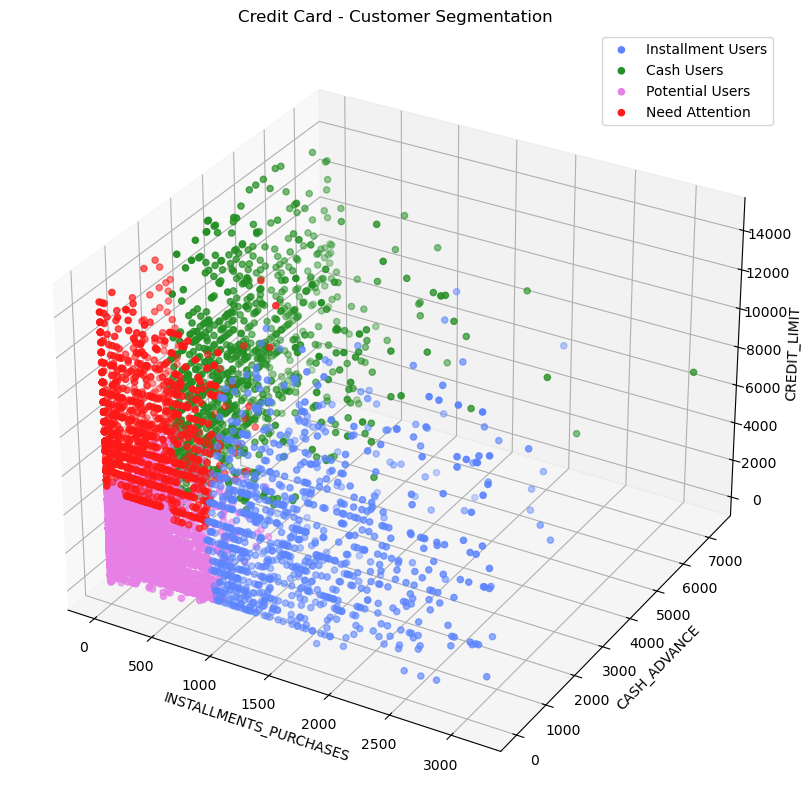

In [179]:
from matplotlib.colors import ListedColormap

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(xs= group0.INSTALLMENTS_PURCHASES,ys=group0.CASH_ADVANCE,zs= group0.CREDIT_LIMIT, c=group0.prediction, label = 'Installment Users', cmap = ListedColormap('#5C85FF'))
ax.scatter(xs= group1.INSTALLMENTS_PURCHASES,ys=group1.CASH_ADVANCE,zs= group1.CREDIT_LIMIT, c=group1.prediction, label = 'Cash Users', cmap = ListedColormap('#248F24'))
ax.scatter(xs= group2.INSTALLMENTS_PURCHASES,ys=group2.CASH_ADVANCE,zs= group2.CREDIT_LIMIT, c=group2.prediction, label = 'Potential Users', cmap = ListedColormap('#E680E6'))
ax.scatter(xs= group3.INSTALLMENTS_PURCHASES,ys=group3.CASH_ADVANCE,zs= group3.CREDIT_LIMIT, c=group3.prediction, label = 'Need Attention', cmap = ListedColormap('#FF1919'))


# Set axis labels
ax.set_xlabel('INSTALLMENTS_PURCHASES')
ax.set_ylabel('CASH_ADVANCE')
ax.set_zlabel('CREDIT_LIMIT')

plt.legend()
plt.title('Credit Card - Customer Segmentation')
plt.show()